In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm
import pandas as pd

# sys.path.append('..')
from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn import metrics
import preprocessing.features
from os.path import join as oj

# load results

In [2]:
dirs = ["results/db5_saliency_warmstart_lamL1wave=0.01_seed=100"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(".", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.1).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

# Plotting

In [ ]:
res = results[0]
mos = models[0]
lamL1attr = np.array(res['lamL1attr'])
index = {}
for i in range(len(lamL1attr)):
    index[i] = np.argsort(lamL1attr)[i]
    
ix = 13
wt = mos[index[ix]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index[ix]], res['lamL1attr'][index[ix]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index[ix]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][index[ix]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][index[ix]], res['L1inputxgrad_loss'][index[ix]]))

# original wavelet
wt_o = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
filt_o = get_1dfilts(wt_o)
phi_o, psi_o, x_o = get_wavefun(wt_o)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_1dfilts(filt_o, is_title=True, figsize=(2,2))

plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1), flip_wavelet=True)
plot_wavefun((phi_o, psi_o, x_o), is_title=True, figsize=(3,1))

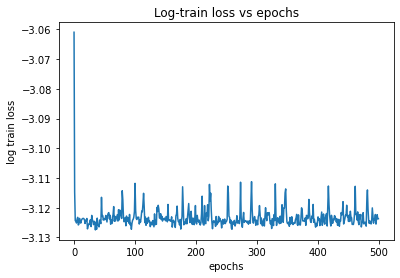

In [7]:
plt.plot(np.log(res['train_losses'][index[ix]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

## load data and model

In [8]:
# get dataloader and model
# (train_loader, test_loader), model = load_dataloader_and_pretrained_model(p)
# torch.manual_seed(p.seed)



# load data and model
(train_loader, test_loader) = get_dataloader(p.data_path, 
                             batch_size=p.batch_size,
                             is_continuous=p.is_continuous)   

model = load_pretrained_model(p.model_path, device=device) 
data = iter(test_loader).next()[0].to(device)

Reconstruction error=0.00004


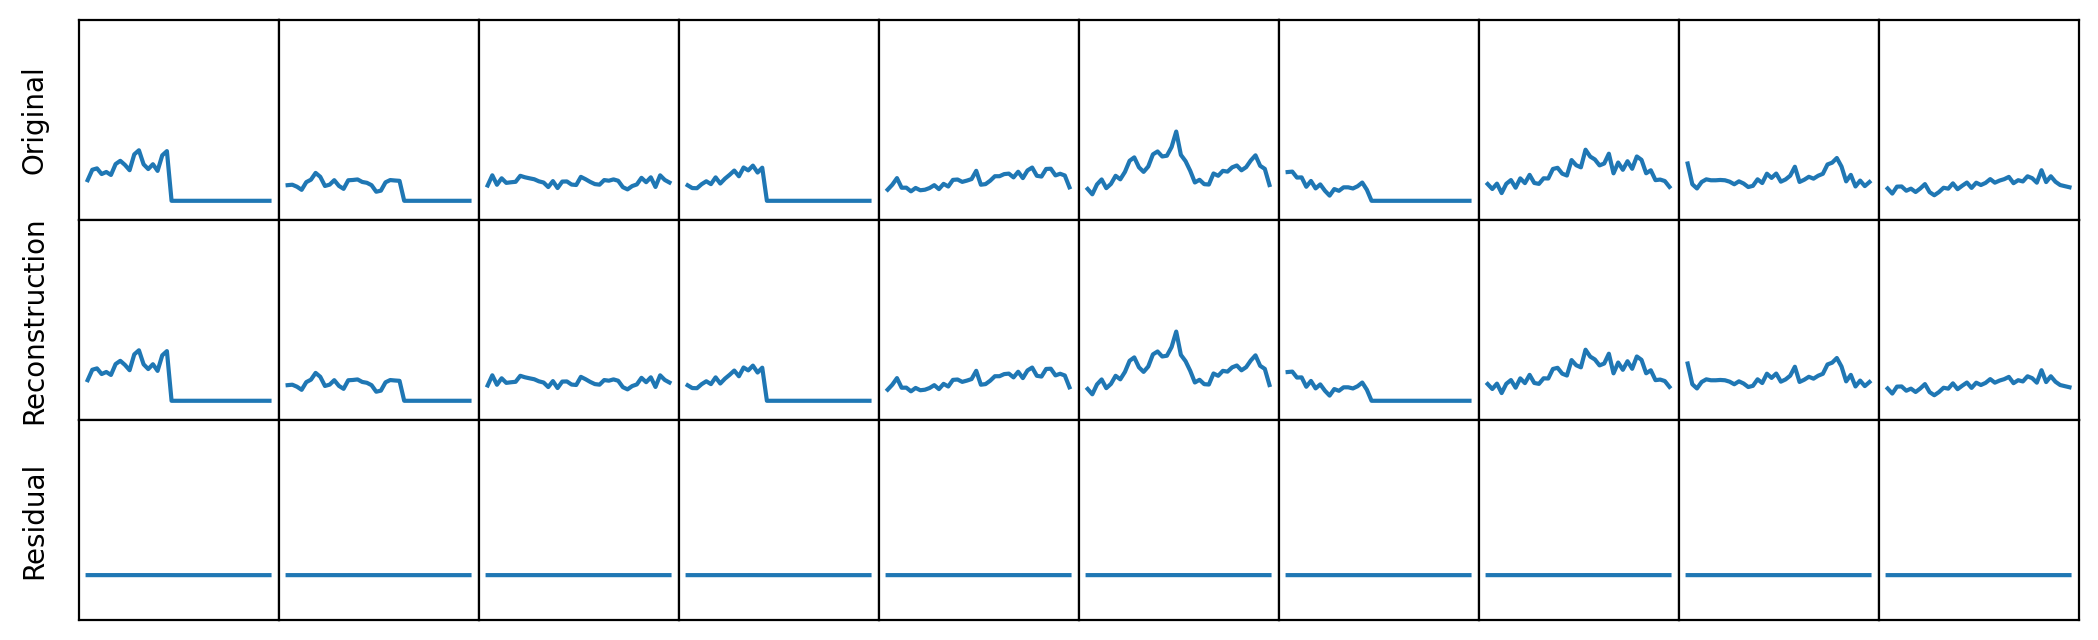

In [9]:
#### plot original and reconstruction images
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))
plot_1dreconstruct(data, recon)

In [10]:
# # validator 
validator = Validator(model, test_loader)

# # original wavelet transform
model.train()
rec_loss, sum_loss, hsum_loss, L2norm_loss, CMF_loss, conv_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(wt, target=p.target)
rec_loss_o, sum_loss_o, hsum_loss_o, L2norm_loss_o, CMF_loss_o, conv_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o = validator(wt_o, target=p.target)

print("\n\n \t Original filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f} \n \
         Adaptive filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f}"\
          .format(rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o, 
                  rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss))



 	 Original filter:Reconstruction Error=0.00000 sum loss=0.00000 L2norm loss=0.00000 CMF loss=0.00000 L1wave loss=4.32779 L1saliency loss=0.42663 L1inputxgrad loss=0.27994 
          Adaptive filter:Reconstruction Error=0.00003 sum loss=0.00000 L2norm loss=0.00000 CMF loss=0.00000 L1wave loss=3.93337 L1saliency loss=0.37496 L1inputxgrad loss=0.28563


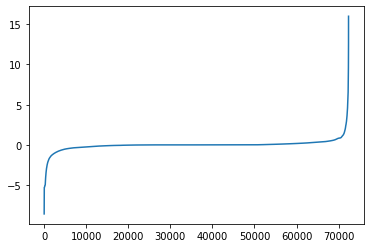

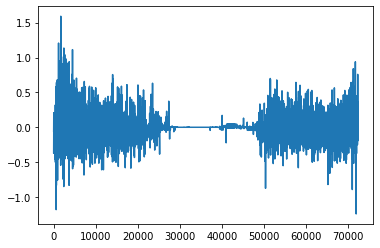

In [11]:
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

mt = TrimModel(model, wt.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

b = torch.tensor([]).to(device)
c = torch.tensor([]).to(device)
for data, _ in test_loader:
    data = data.to(device)
    data_t = wt(data)
    attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
    y, _ = tuple_to_tensor(data_t)
    b = torch.cat((y,b), dim=0)     
    z, _ = tuple_to_tensor(attributions)
    c = torch.cat((z,c), dim=0)
b = b.reshape(-1)
c = c.reshape(-1)
sort_indexes = torch.argsort(b, dim=0, descending=False)          
    
plt.plot(b[sort_indexes].detach().cpu())
plt.show()

plt.plot(c[sort_indexes].detach().cpu())
plt.show()

# calculate accuracy

In [12]:
def dataloader_to_nparrays(w_transform, train_loader, test_loader):
    w_transform = w_transform.to('cpu')
    J = w_transform.J
    X = []
    y = []
    for data, labels in train_loader:
        data_t = w_transform(data)
        for j in range(J+1):
            if j == 0:
                x = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
            else:
                x = torch.cat((x, torch.max(data_t[j].detach(), dim=2)[0]), axis=1)    
        X.append(x)
        y.append(labels)
    X = torch.cat(X).squeeze().numpy()
    y = torch.cat(y).squeeze().numpy()

    X_test = []
    y_test = []
    for data, labels in test_loader:
        data_t = w_transform(data)
        for j in range(J+1):
            if j == 0:
                x = deepcopy(torch.max(data_t[j].detach(), dim=2)[0])
            else:
                x = torch.cat((x, torch.max(data_t[j].detach(), dim=2)[0]), axis=1)              
        X_test.append(x)
        y_test.append(labels)
    X_test = torch.cat(X_test).squeeze().numpy()
    y_test = torch.cat(y_test).squeeze().numpy()   
    
    return (X, y), (X_test, y_test)

In [193]:

r = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],    
    'LSTM': [],
}
for use_reg in [True, False]:
    (train_loader, test_loader) = get_dataloader(p.data_path, 
                                 batch_size=p.batch_size,
                                 is_continuous=use_reg)   


    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = dataloader_to_nparrays(wt, train_loader, test_loader)
    
    if use_reg:
        clf = LinearRegression().fit(X, y)
        preds = clf.predict(X_test)
        error = metrics.r2_score(y_test, preds)
    #     error = metrics.mean_squared_error(y_test, preds)
    else:
        clf = LogisticRegression().fit(X, y)
        preds = clf.predict(X_test)
        preds = 1 * (preds > 0)
        error = metrics.accuracy_score(y_test, preds)
    r['AWD (Ours)'].append(error)

    wt_o = wt_o.to('cpu')
    (X, y), (X_test, y_test) = dataloader_to_nparrays(wt_o, train_loader, test_loader)
#     clf_o = LinearRegression().fit(X, y)
#     preds = clf_o.predict(X_test)
    if use_reg:
    #     error = metrics.mean_squared_error(y_test, preds)
        clf_o = LinearRegression().fit(X, y)
        preds = clf_o.predict(X_test)
        error = metrics.r2_score(y_test, preds)
    else:
        clf_o = LogisticRegression().fit(X, y)
        preds = clf_o.predict(X_test)
        preds = 1 * (preds > 0)
        error = metrics.accuracy_score(y_test, preds)
    r['Standard Wavelet (DB5)'].append(error)

    preds = []
    y = []
    for data, labels in test_loader:   
        preds.append(model(data).detach().numpy())
        y.append(labels.detach().numpy())
    preds = np.vstack(preds)
    y = np.vstack(y)
    if use_reg:
    #     error = metrics.mean_squared_error(y_test, preds)
        error = metrics.r2_score(y_test, preds)
    else:
        preds = 1 * (preds > 0)
        error = metrics.accuracy_score(y_test, preds)
    r['LSTM'].append(error)
scores = pd.DataFrame.from_dict(r).round(3)
scores.index = ['Regression (R2 score)', 'Classification accuracy']

In [194]:
print(scores.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Standard Wavelet (DB5) &  AWD (Ours) &   LSTM \\
\midrule
Regression (R2 score)   &                   0.161 &       0.193 &  0.237 \\
Classification accuracy &                   0.690 &       0.702 &  0.709 \\
\bottomrule
\end{tabular}



# transfer to full data

In [155]:
DIR_PROCESSED = '/scratch/users/vision/data/abc_data/data_processed/processed'
df = pd.read_pickle(oj(DIR_PROCESSED, 'df_full.pkl'))
df = preprocessing.features.normalize_track(df, track='X_same_length', by_time_point=False) # adds X_same_length_normalized
df = df[~df.short & ~df.hotspots] # filter out easy/invalid tracks

In [156]:
dset_names = sorted(df['dset'].unique())
ks = []
for d in dset_names:
    ks += [f'r2', f'r2_wt', f'r2_wt_o',
           f'acc', f'acc_wt', f'acc_wt_o',]
scores = {
    k: [] for k in ks
}
    # test on all test sets
for test_set_name in dset_names:
    d = df[(df['dset'] == test_set_name) & (df['split'] == 'test')]
    X = torch.Tensor(np.vstack(d['X_same_length_normalized'].values))

    preds_reg = model(X).flatten()
    preds_class = (preds_reg > 0).numpy().astype(int)
    # preds_reg_dasc = dasc_model.predict(d['X_d1'].values.reshape(-1, 1))
    coefs = wt(X.unsqueeze(0))
    coefs_max = np.vstack([np.max(coefs[i].detach().numpy(), axis=2).flatten()
            for i in range(len(coefs))]).T
    preds_wt = clf.predict(coefs_max)
    preds_class_wt = (preds_wt > 0).astype(int)
    
   
    coefs = wt_o(X.unsqueeze(0))
    coefs_max = np.vstack([np.max(coefs[i].detach().numpy(), axis=2).flatten()
            for i in range(len(coefs))]).T
    preds_wt_o = clf_o.predict(coefs_max)
    preds_class_wt_o = (preds_wt_o > 0).astype(int)
   
    scores[f'r2'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_reg))
    scores[f'acc'].append(metrics.accuracy_score(d['y_consec_thresh'], preds_class))
    
    print('shapes', d.shape, preds_reg.shape, preds_wt.shape)
    scores[f'r2_wt'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_wt))
    scores[f'acc_wt'].append(metrics.accuracy_score(d['y_consec_thresh'], preds_class_wt))
    
    scores[f'r2_wt_o'].append(metrics.r2_score(d['Y_sig_mean_normalized'], preds_wt_o))
    scores[f'acc_wt_o'].append(metrics.accuracy_score(d['y_consec_thresh'], preds_class_wt_o))    
#     print(scores)
scores = pd.DataFrame.from_dict(scores)
scores.index = dset_names
scores

shapes (535, 72) torch.Size([535]) (535,)
shapes (1067, 72) torch.Size([1067]) (1067,)
shapes (1703, 72) torch.Size([1703]) (1703,)
shapes (679, 72) torch.Size([679]) (679,)
shapes (9367, 72) torch.Size([9367]) (9367,)
shapes (1498, 72) torch.Size([1498]) (1498,)


,r2,r2_wt,r2_wt_o,acc,acc_wt,acc_wt_o
clath_aux+gak,0.325367,0.314928,0.348848,0.685981,0.702804,0.710280
clath_aux+gak_a7d2,0.226579,0.218282,0.197366,0.630740,0.613871,0.629803
clath_aux+gak_a7d2_new,0.240627,0.303213,0.349786,0.702290,0.731063,0.760423
clath_aux+gak_new,0.210387,0.228209,0.206207,0.441826,0.562592,0.637703
clath_aux_dynamin,0.253281,0.128933,0.140453,0.722323,0.748479,0.798335
clath_gak,0.230425,0.110639,0.116864,0.683578,0.698264,0.714953


In [157]:
scores.round(2).style.background_gradient()

,r2,r2_wt,r2_wt_o,acc,acc_wt,acc_wt_o
clath_aux+gak,0.330000,0.310000,0.350000,0.690000,0.700000,0.710000
clath_aux+gak_a7d2,0.230000,0.220000,0.200000,0.630000,0.610000,0.630000
clath_aux+gak_a7d2_new,0.240000,0.300000,0.350000,0.700000,0.730000,0.760000
clath_aux+gak_new,0.210000,0.230000,0.210000,0.440000,0.560000,0.640000
clath_aux_dynamin,0.250000,0.130000,0.140000,0.720000,0.750000,0.800000
clath_gak,0.230000,0.110000,0.120000,0.680000,0.700000,0.710000
